In [2]:
import copy
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import wrds
from IPython.display import display

start = '2000-01-01'
end = '2019-12-31'

In [3]:
DOWNLOAD = False
if DOWNLOAD:
        
    # connect to databse and download csv files (run once)
    db = wrds.Connection(wrds_username = 'kuriyoki')
    db.create_pgpass_file() # run once

    # download brk data  
    vwret = db.raw_sql("select date, vwretd "
                     " from crsp.msi "
                     "where date>='{}' and date<='{}'".format(start, end))
    
    stonks = db.raw_sql("select a.permno, a.date, a.prc, a.shrout, a.ret, b.shrcd, b.exchcd "
                     "from crsp.msf as a left join crsp.msenames as b "
                     "on a.permno=b.permno "
                     "and b.namedt <= a.date "
                     "and a.date <= b.nameendt "
                     "where b.exchcd in (1, 2) "
                     "and b.shrcd in (10, 11) "
                     "and date>='{}' and date<='{}'".format(start, end))
    
    riskfree = db.raw_sql("select mcaldt, tmytm "
                        "from crsp.tfz_mth_rf "
                        "where kytreasnox = 2000001 and "
                        "mcaldt>='{}' and mcaldt<='{}'".format(start, end))

    # index to datetime
    vwret = vwret.set_index('date')
    stonks = stonks.set_index('date')
    riskfree = riskfree.set_index('mcaldt')

    # write to csv
    vwret.to_csv('vwret.csv')
    stonks.to_csv('stonks.csv')
    riskfree.to_csv('riskfree.csv')
else:
    vwret = pd.read_csv('vwret.csv', index_col = 'date')
    stonks = pd.read_csv('stonks.csv', index_col = 'date')
    riskfree = pd.read_csv('riskfree.csv', index_col = 'mcaldt')
    
    

##%%

stonks = stonks.reset_index().set_index(['date', 'permno']).sort_index()
nr_observations = stonks.groupby(['permno']).count()
good_stonks = nr_observations[(nr_observations['prc'] >= 240) & (nr_observations['ret'] >= 240)]
stonks = stonks[stonks.index.get_level_values('permno').isin(good_stonks.index.tolist())]


##%% Process the data, filter out stocks with insufficient observations
# Take only stocks with sufficient observations
# Transform to excess returns

riskfree.columns = ['rf']
riskfree['rf'] = riskfree['rf']/100

# De-annualize
riskfree['rf'] = riskfree['rf']/12

riskfree.index = riskfree.index.rename('date')

stonks = stonks.reset_index()

stonks = stonks.merge(riskfree, left_on='date', right_on='date')
stonks = stonks.merge(vwret, left_on='date', right_on='date')

stonks = stonks.set_index(['date', 'permno'])
stonks['ret-rf'] = stonks['ret'] - stonks['rf']

# The prc is negative if the cloing price on a certain day
# is not available and the price is instead computed as the
# average of the bid and ask.
stonks['mcap'] = stonks['prc'].abs()*stonks['shrout']

##%% 


def compute_beta(eret, mkt):
    return eret.cov(mkt) / mkt.var()

def compute_alpha(eret, mkt):
    return (eret.mean() - compute_beta(eret, mkt)*mkt.mean())

stonks = stonks.sort_index()

bins_all = stonks.groupby('date')['mcap'].transform(lambda x: pd.qcut(x, 10, labels=False))
# Get the bins for the last month
bin_mcap_last = bins_all.loc['2019-12-31']
# Copy the bins for the last month to all the other months
bins_last = stonks.groupby('date')['mcap'].transform(lambda x: bin_mcap_last)
bins_last.name = 'bin-mcap-last'
stonks['bin-mcap-last'] = bins_last

lagged_mcap = stonks[['mcap']].groupby('permno').shift(1)
stonks['mcap-lagged']=lagged_mcap['mcap']

bins_all = stonks.groupby('date')['mcap-lagged'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))
bins_all.name = 'bin-mcap-lagged'
stonks['bin-mcap-lagged'] = bins_all

In [4]:
# Compute the alphas and betas of the portfolios

def regression_results(portfolios, bin_name, return_name):
    beta = portfolios.groupby([bin_name]).apply(lambda x: compute_beta(x[return_name], vwret['vwretd']))
    alpha = portfolios.groupby([bin_name]).apply(lambda x: compute_alpha(x[return_name], vwret['vwretd']))
    return beta, alpha

def compute_alphas_betas(bin_name):
    wret = stonks.groupby([bin_name, 'date']).apply(lambda x: (x['ret-rf'].dot(x['mcap-lagged']))/x['mcap-lagged'].sum())
    eret = stonks.groupby([bin_name, 'date'])['ret-rf'].mean()
    portfolios = pd.DataFrame.from_dict({'ret-rf_e': eret, 'ret-rf_w': wret})

    print(portfolios)
    beta_e, alpha_e = regression_results(portfolios, bin_name, 'ret-rf_e')
    beta_w, alpha_w = regression_results(portfolios, bin_name, 'ret-rf_w')

    to_merge = pd.DataFrame({'beta_e': beta_e, 'alpha_e': alpha_e, 'beta_w': beta_w, 'alpha_w': alpha_w})

    portfolios = portfolios.reset_index()
    portfolios = portfolios.merge(to_merge, how='left', left_on=bin_name, right_on=bin_name)
    portfolios = portfolios.set_index([bin_name, 'date'])
    
    return portfolios


portfolios_last = compute_alphas_betas('bin-mcap-last')
portfolios_lagged = compute_alphas_betas('bin-mcap-lagged')


                          ret-rf_e  ret-rf_w
bin-mcap-last date                          
0.0           2000-01-31  0.045657       NaN
              2000-02-29  0.078977 -0.037183
              2000-03-31 -0.005492  0.014179
              2000-04-28 -0.029590 -0.050556
              2000-05-31 -0.047099 -0.064075
...                            ...       ...
9.0           2019-08-30 -0.008321 -0.012804
              2019-09-30  0.023495  0.023050
              2019-10-31  0.019969  0.016481
              2019-11-29  0.036869  0.033537
              2019-12-31  0.024872  0.024927

[2400 rows x 2 columns]
                            ret-rf_e  ret-rf_w
bin-mcap-lagged date                          
0.0             2000-02-29  0.131243  0.125019
                2000-03-31 -0.013235 -0.039660
                2000-04-28 -0.029885 -0.032727
                2000-05-31 -0.032803 -0.019047
                2000-06-30  0.058113  0.043200
...                              ...       ...
9.0           

In [31]:
portfolios_last = portfolios_last.groupby('bin-mcap-last').mean()
portfolios_lagged = portfolios_lagged.groupby('bin-mcap-lagged').mean()

print(portfolios_last.to_latex())
#print(portfolios_lagged)

\begin{tabular}{lrrrrrr}
\toprule
{} &  ret-rf\_e &  ret-rf\_w &    beta\_e &   alpha\_e &    beta\_w &   alpha\_w \\
bin-mcap-last &           &           &           &           &           &           \\
\midrule
0.0           &  0.008928 & -0.003519 &  1.097198 &  0.002537 &  1.223557 & -0.010647 \\
1.0           &  0.010247 & -0.001188 &  1.222773 &  0.003124 &  1.246237 & -0.008448 \\
2.0           &  0.011706 &  0.004136 &  1.230999 &  0.004535 &  1.085347 & -0.002187 \\
3.0           &  0.011472 &  0.004897 &  1.238775 &  0.004256 &  1.224935 & -0.002239 \\
4.0           &  0.011330 &  0.005356 &  1.009298 &  0.005450 &  0.951568 & -0.000187 \\
5.0           &  0.011898 &  0.005630 &  1.119895 &  0.005375 &  1.084977 & -0.000690 \\
6.0           &  0.012096 &  0.006487 &  1.031097 &  0.006089 &  1.069309 &  0.000258 \\
7.0           &  0.010760 &  0.005853 &  0.915078 &  0.005429 &  1.004329 &  0.000002 \\
8.0           &  0.011037 &  0.005593 &  0.821006 &  0.006254 &  0.88236

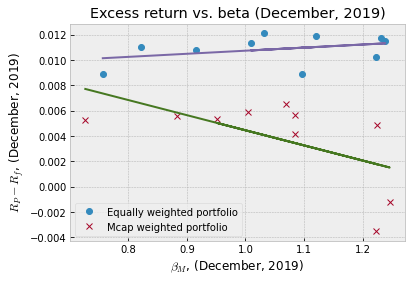

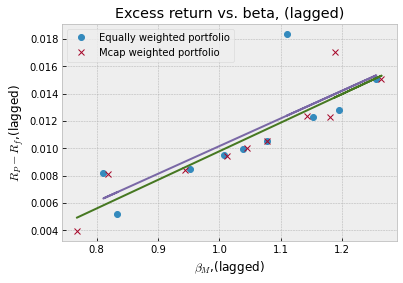

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


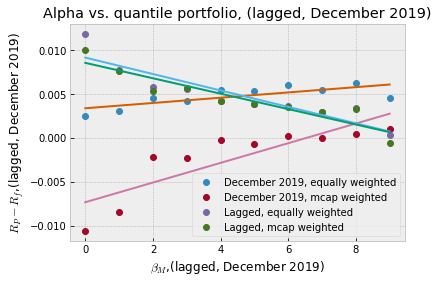

In [35]:
m, b = np.polyfit(portfolios_last['beta_e'], portfolios_last['ret-rf_e'], 1)
mw, bw = np.polyfit(portfolios_last['beta_w'], portfolios_last['ret-rf_w'], 1)
with plt.style.context('bmh'):
    plt.plot(portfolios_last['beta_e'], portfolios_last['ret-rf_e'], 'o', label = 'Equally weighted portfolio') 
    plt.plot(portfolios_last['beta_w'], portfolios_last['ret-rf_w'], 'x', label = 'Mcap weighted portfolio') 
    plt.plot(portfolios_last['beta_e'], m*portfolios_last['beta_e'] + b)
    plt.plot(portfolios_last['beta_w'], mw*portfolios_last['beta_w'] + bw)
    plt.legend()
    plt.title("Excess return vs. beta (December, 2019)")
    plt.xlabel(r'$\beta_M$' ', (December, 2019)')
    plt.ylabel(r'$R_P - R_f$' + ', (December, 2019)')
    plt.savefig('december2019.pdf', format='pdf', transparent=False, pad_inches=0.7)
    plt.show()
#plt.plot(portfolios_last['ret-rf_w'])


m, b = np.polyfit(portfolios_lagged['beta_e'], portfolios_lagged['ret-rf_e'], 1)
mw, bw = np.polyfit(portfolios_lagged['beta_w'], portfolios_lagged['ret-rf_w'], 1)
with plt.style.context('bmh'):
    plt.plot(portfolios_lagged['beta_e'], portfolios_lagged['ret-rf_e'], 'o', label = 'Equally weighted portfolio') 
    plt.plot(portfolios_lagged['beta_w'], portfolios_lagged['ret-rf_w'], 'x', label = 'Mcap weighted portfolio') 
    plt.plot(portfolios_lagged['beta_e'], m*portfolios_lagged['beta_e'] + b)
    plt.plot(portfolios_lagged['beta_w'], mw*portfolios_lagged['beta_w'] + bw)
    plt.legend()
    plt.title("Excess return vs. beta, (lagged)")
    plt.xlabel(r'$\beta_M$' ',(lagged)')
    plt.ylabel(r'$R_P - R_f$' + ',(lagged)')
    plt.savefig('lagged.pdf', format='pdf', transparent=False, pad_inches=0.7)
    plt.show()
#plt.plot(portfolios_last['ret-rf_w'])


indexlist = portfolios_lagged.index.to_numpy()
print(indexlist)

m, b = np.polyfit(indexlist, portfolios_last['alpha_e'], 1)
mw, bw = np.polyfit(indexlist, portfolios_last['alpha_w'], 1)
ml, bl = np.polyfit(indexlist, portfolios_lagged['alpha_e'], 1)
mwl, bwl = np.polyfit(indexlist, portfolios_lagged['alpha_w'], 1)

with plt.style.context('bmh'):
    plt.plot(indexlist, portfolios_last['alpha_e'], 'o', label='December 2019, equally weighted') 
    plt.plot(indexlist, portfolios_last['alpha_w'], 'o', label='December 2019, mcap weighted') 
    plt.plot(indexlist, portfolios_lagged['alpha_e'], 'o', label='Lagged, equally weighted') 
    plt.plot(indexlist, portfolios_lagged['alpha_w'], 'o', label='Lagged, mcap weighted') 
    
    plt.plot(indexlist, m*(indexlist) + b)
    plt.plot(indexlist, mw*indexlist + bw)
    plt.plot(indexlist, ml*indexlist + bl)
    plt.plot(indexlist, mwl*indexlist + bwl)
    plt.legend()
    plt.title("Alpha vs. quantile portfolio, (lagged, December 2019)")
    plt.xlabel(r'$\beta_M$' ',(lagged, December 2019)')
    plt.ylabel(r'$R_P - R_f$' + ',(lagged, December 2019)')
    plt.savefig('alphas.pdf', format='pdf', transparent=False, pad_inches=0.7)
    plt.show()
#plt.plot(portfolios_last['ret-rf_w'])